In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import pandas as pd
from scipy.io import loadmat

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline

from pyriemann.classification import MDM, FgMDM, TSclassifier
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from mne.decoding import CSP
from tqdm.notebook import trange, tqdm

%matplotlib inline

In [86]:
l_freq, h_freq = 8, 30
start, stop = 3.5, None
scoring = 'accuracy'

In [87]:
subjects = ["P{:02d}T".format(i) for i in range(1, 9)]
path= "../../datasets/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow/parsed_"
sfreq = 512
channel_names = ["F3", "FC3", "C3", "CP3", "P3", "FCz", "CPz", "F4", "FC4", "C4", "CP4", "P4"]
channel_types = 12 * ["eeg"]
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(channel_names, sfreq, channel_types, montage)
tmin = 0.
event_id = {'right':1 , 'left':2}

ep = []
#ep_y = []
for s in subjects:
    d = loadmat(path+s+".mat", squeeze_me=True)
    labels = d['Labels']
    data = d['RawEEGData']
    events = np.array([[t*10*sfreq, 0, l] for t, l in enumerate(labels)])
    epochs =  mne.EpochsArray(data, info, events, tmin, event_id)
    epochs.set_montage(montage)
    epochs.filter(l_freq=l_freq, h_freq=h_freq, method='iir')
    epochs.crop(tmin=start, tmax=stop)
    ep.append(epochs)
    #ep_y.append(labels)

80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB



<ipython-input-87-0f3cba52a069>:7: DeprecationWarning: Passing montage to create_info is deprecated and will be removed in 0.21, use raw.set_montage (or epochs.set_montage, etc.) instead
  info = mne.create_info(channel_names, sfreq, channel_types, montage)


80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
-------------

In [112]:
ep[0]

<EpochsArray  |   80 events (all good), 3.5 - 7.99805 sec, baseline off, ~16.9 MB, data loaded,
 'left': 40
 'right': 40>

In [111]:
param_svc = {'C': np.logspace(-2, 2, 10)}
gssvc = GridSearchCV(SVC(kernel='linear'), param_svc, cv=3)
param_elasticnet = {'1_ratio': 1 - np.logspace(-2, 0, 10),
                    'cv': 3}
elasticnetcv = ElasticNetCV(*param_elasticnet)

pipelines = {}
pipelines['MDM'] = make_pipeline(
    Covariances(estimator='oas'),
    MDM(metric='riemann', n_jobs=-1))
pipelines['fgMDM'] = make_pipeline(
    Covariances(estimator='oas'),
    FgMDM(metric='riemann', tsupdate=False, n_jobs=-1))
pipelines['TS_SVM'] = make_pipeline(
    Covariances(estimator='oas'),
    TangentSpace(metric='riemann'),
    gssvc)
#pipelines['TS_GLM'] = make_pipeline(
#    Covariances(estimator='lwf'),
#    TangentSpace(metric='riemann'),
#    elasticnetcv)

pipelines['CSP_LDA'] = make_pipeline(
    CSP(n_components=6), 
    LDA())
pipelines['CSP_SVM'] = make_pipeline(
    CSP(n_components=6), 
    gssvc)
#pipelines['CSP_GLM'] = make_pipeline(
#    CSP(n_components=6), 
#    elasticnetcv)

In [113]:
cv = LeaveOneOut()
all_res = []
for i, s in enumerate(tqdm(subjects)):
    print (s)
    X = ep[i].get_data()
    y = epochs.events[:,-1]
    le = LabelEncoder()
    y = le.fit_transform(y)

    for name in tqdm(pipelines):
        acc = cross_val_score(pipelines[name], X, y, cv=cv, scoring=scoring)
        res = {'subject': str(s),
               'score': acc.mean(),
               'pipeline': name}
        all_res.append(res)
df_std = pd.DataFrame(all_res)

P01T


Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag)

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating

Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating

Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating

Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating

Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 23 (2.2e-16 eps * 12 dim * 8.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 34 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag)

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating c

Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating c

Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating c

Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 35 (2.2e-16 eps * 12 dim * 1.3e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 12 dim * 1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating c

Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 5.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.3e+15  max singular value)
    Estimated rank (

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.2e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 12 dim * 6.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 12 dim * 6.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 18 (2.2e-16 eps * 12 dim * 6.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 12 dim * 6.9e+15  max singular value)
    Estimated rank (

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 12 dim * 7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 12 dim * 7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Don

Computing rank from data with rank=None
    Using tolerance 18 (2.2e-16 eps * 12 dim * 6.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 18 (2.2e-16 eps * 12 dim * 6.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.2e+15  max singular value)
    Estimated rank (

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 18 (2.2e-16 eps * 12 dim * 6.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 12 dim * 7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 12 dim * 7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating c

Done.
Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 12 dim * 7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 12 dim * 7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 18 (2.2e-16 eps * 12 dim * 6.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 18 (2.2e-16 eps * 12 dim * 6.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 12 dim * 7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 12 dim * 7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 18 (2.2e-16 eps * 12 dim * 6.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimati

Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 18 (2.2e-16 eps * 12 dim * 6.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 18 (2.2e-16 eps * 12 dim * 6.9e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 12 dim * 7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 12 dim * 7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Don

Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

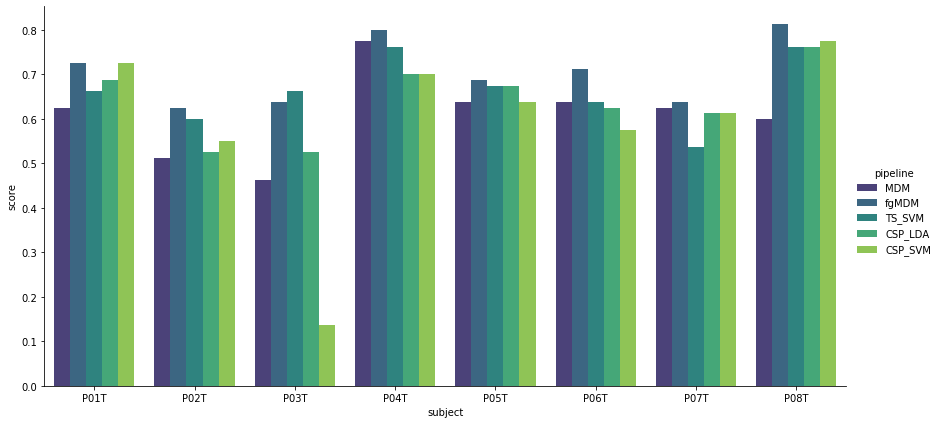

In [114]:
sns.catplot(x='subject', y='score', hue='pipeline', kind='bar', data=df_std, height=6, aspect=2, palette="viridis")
plt.savefig("covariance-subject.png")

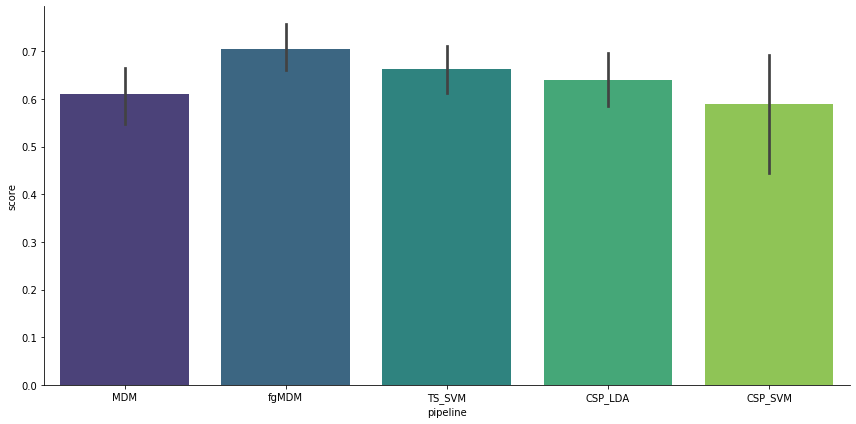

In [115]:
sns.catplot(x='pipeline', y='score', kind='bar', data=df_std, height=6, aspect=2, palette="viridis")
plt.savefig("covariance-classif.png")

In [116]:
df_std[df_std['pipeline'] == "fgMDM"]["score"].to_numpy()

array([0.725 , 0.625 , 0.6375, 0.8   , 0.6875, 0.7125, 0.6375, 0.8125])

In [117]:
df_std[df_std['pipeline'] == "fgMDM"]["score"].to_numpy().mean()

0.7046874999999999

# Predict

# Todo

Try GLMnet